<a href="https://colab.research.google.com/github/MeeraReji/Unveiling-Voices-Noise-Dissipation-with-Multi-Speaker-Separation-Using-Deep-Learning/blob/main/pipelined_gui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

1/1 [==============================] - 0s 129ms/step
The predicted class for the sample audio is: Computer_keyboard
Predicted probabilities: [3.1137334e-03 1.9310904e-01 2.6673150e-10 8.0377722e-01]
Waveformer script output: Downloading model configuration from https://targetsound.cs.washington.edu/files/default_config.json:

Loaded input audio from /content/mono_audio.wav
Inference done. Saving output audio to /content/output_audio.wav

Waveformer script error (if any): 
Waveformer model has processed the audio with target: Computer_keyboard


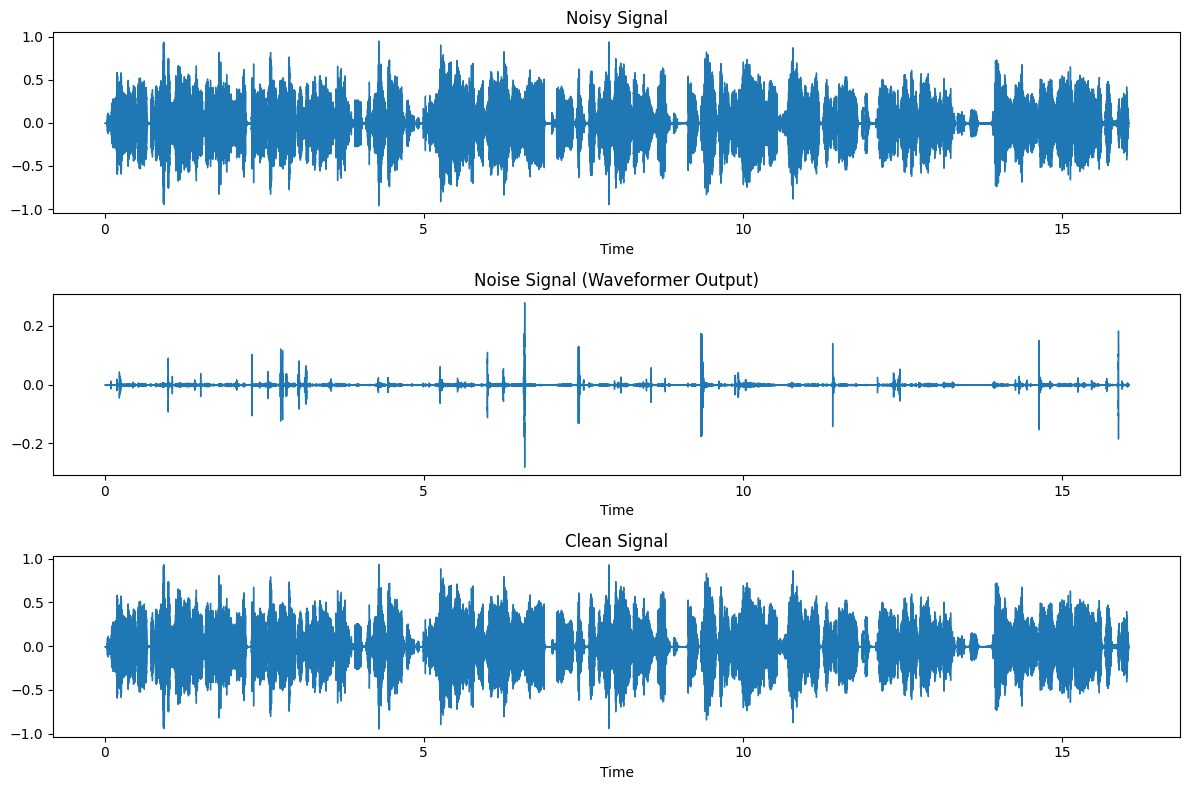

Enter the number of speakers in the audio (1-4): 2
Two speakers detected. Using Sepformer for 2 speakers.


hyperparams.yaml:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Resampling the audio from 44100 Hz to 8000 Hz
Separated audio paths: ['/content/output/source1hat.wav', '/content/output/source2hat.wav']


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
import subprocess
import os
import soundfile as sf
import matplotlib.pyplot as plt
import torchaudio
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)

# Load your trained model
model = load_model(model_path)

# Path to your sample audio file
sample_audio_file = '/content/mixed_eng.mp3'

# Extract features from the sample audio file
max_length = 700  # Adjust to match the model's expected input length
sample_features = extract_features(sample_audio_file, max_length=max_length)

# Reshape and preprocess the input for prediction
sample_features = sample_features[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Make predictions
predictions = model.predict(sample_features)

# Interpret predictions
predicted_label = np.argmax(predictions)
class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
predicted_class = class_labels[predicted_label]

print(f'The predicted class for the sample audio is: {predicted_class}')
print(f'Predicted probabilities: {predictions.squeeze()}')  # Optional: Print probabilities for each class

# Clone the Waveformer repository and install dependencies if not already done
if not os.path.exists('Waveformer'):
    subprocess.run('git clone https://github.com/vb000/Waveformer', shell=True)
os.chdir('Waveformer')
subprocess.run('pip install -r requirements.txt', shell=True)
subprocess.run('pip install wget', shell=True)
subprocess.run('pip install speechbrain', shell=True)
subprocess.run('pip install torchmetrics', shell=True)

# Convert the input audio to mono
y, sr = librosa.load(sample_audio_file, sr=None, mono=True)
mono_audio_file = '/content/mono_audio.wav'
sf.write(mono_audio_file, y, sr)

# Run the Waveformer model with the predicted class as the target
waveformer_input = f'python Waveformer.py "{mono_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
result = subprocess.run(waveformer_input, shell=True, capture_output=True, text=True)

# Debugging output from Waveformer script execution
print("Waveformer script output:", result.stdout)
print("Waveformer script error (if any):", result.stderr)

# Check if the output file was created
output_audio_path = '/content/output_audio.wav'
if not os.path.exists(output_audio_path):
    raise FileNotFoundError(f"The output audio file was not found at {output_audio_path}")

print(f'Waveformer model has processed the audio with target: {predicted_class}')

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    """Pad or trim the signal to the target length."""
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    # Pad or trim the noise signal to match the length of the noisy signal
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))

    # Calculate STFT of noisy and noise signals
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)

    # Compute the magnitude and phase
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)

    # Initialize the estimated magnitude of the clean signal
    magnitude_clean = magnitude_noisy.copy()

    # Initialize the noise estimate with the first few frames
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    # Perform spectral subtraction with smoothing
    for t in range(magnitude_noisy.shape[1]):
        # Update noise estimate using a smoothing factor
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]

        # Subtract noise estimate from the noisy signal magnitude
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    # Reconstruct the signal using the original phase
    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)

    return clean_signal

# Load the original noisy audio file
noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
# Load the noise output from the Waveformer model
noise_signal, _ = librosa.load(output_audio_path, sr=sr)

# Apply spectral subtraction
clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

# Save the clean audio
sf.write('/content/clean_signal.wav', clean_signal, sr)

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(noisy_signal, sr=sr)
plt.title('Noisy Signal')
plt.subplot(3, 1, 2)
librosa.display.waveshow(noise_signal, sr=sr)
plt.title('Noise Signal (Waveformer Output)')
plt.subplot(3, 1, 3)
librosa.display.waveshow(clean_signal, sr=sr)
plt.title('Clean Signal')
plt.tight_layout()
plt.show()

# Now take the output of the spectral subtraction as the input to the Sepformer below

!pip install speechbrain

def detect_speakers(path):
    # This function is a placeholder for actual speaker detection logic
    # Ideally, you would use a pre-trained model or other heuristic to detect the number of speakers
    # Here, we'll use a dummy implementation for illustration purposes
    # Return 1 for one speaker, 2 for two speakers, etc.
    return int(input("Enter the number of speakers in the audio (1-4): "))  # Dummy user input for demonstration

def clear_output_directory(output_dir):
    # Remove all files in the output directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

def separate_audio(path, num_speakers):
    # Define the output directory
    output_dir = "/content/output"
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Clear the output directory
    clear_output_directory(output_dir)

    if (num_speakers == 1):
        print("Single speaker detected. Returning original audio.")
        return path  # Return the original path

    elif num_speakers == 2:
        print("Two speakers detected. Using Sepformer for 2 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav")]

    elif num_speakers == 3:
        print("Three speakers detected. Using Sepformer for 3 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav")]

    elif num_speakers == 4:
        print("Four speakers detected. Using Sepformer for 4 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj04mix", savedir='pretrained_models/sepformer-wsj04mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source4hat.wav"), est_sources[:, :, 3].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav"), os.path.join(output_dir, "source4hat.wav")]

    else:
        print("Unsupported number of speakers. Returning original audio.")
        return path  # Return the original path

# Load clean signal and detect the number of speakers
clean_audio_path = '/content/clean_signal.wav'
num_speakers = detect_speakers(clean_audio_path)

# Separate audio based on the number of detected speakers
separated_audio_paths = separate_audio(clean_audio_path, num_speakers)
print("Separated audio paths:", separated_audio_paths)


1/1 [==============================] - 0s 250ms/step
The predicted class for the sample audio is: Computer_keyboard
Predicted probabilities: [3.1137334e-03 1.9310904e-01 2.6673150e-10 8.0377722e-01]
Waveformer script output: Downloading model configuration from https://targetsound.cs.washington.edu/files/default_config.json:

Loaded input audio from /content/mono_audio.wav
Inference done. Saving output audio to /content/output_audio.wav

Waveformer script error (if any): 
Waveformer model has processed the audio with target: Computer_keyboard


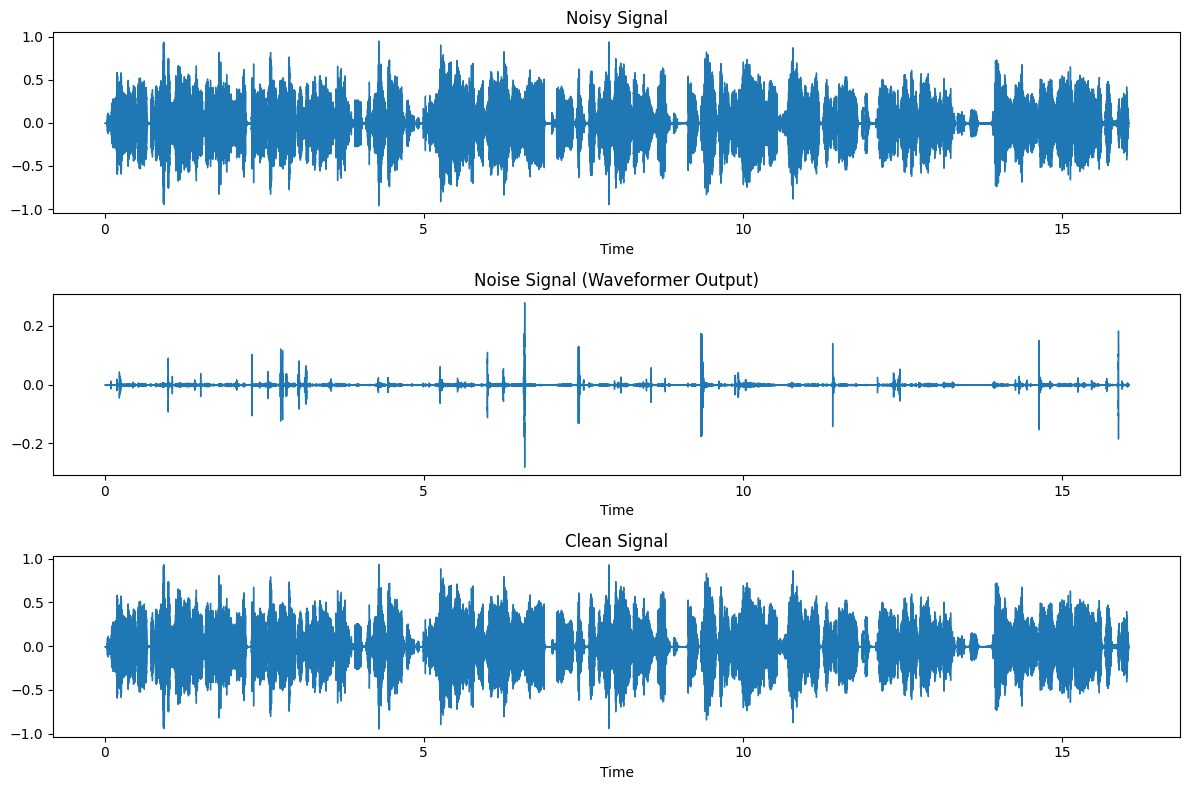

Enter the number of speakers in the audio (1-4): 2
Two speakers detected. Using Sepformer for 2 speakers.


hyperparams.yaml:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Resampling the audio from 44100 Hz to 8000 Hz
Separated audio paths: ['/content/output/source1hat.wav', '/content/output/source2hat.wav']


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
import subprocess
import os
import soundfile as sf
import matplotlib.pyplot as plt
import torchaudio
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)

# Load your trained model
model = load_model(model_path)

# Path to your sample audio file
sample_audio_file = '/content/mixed_eng.mp3'

# Extract features from the sample audio file
max_length = 700  # Adjust to match the model's expected input length
sample_features = extract_features(sample_audio_file, max_length=max_length)

# Reshape and preprocess the input for prediction
sample_features = sample_features[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Make predictions
predictions = model.predict(sample_features)

# Interpret predictions
predicted_label = np.argmax(predictions)
class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
predicted_class = class_labels[predicted_label]

print(f'The predicted class for the sample audio is: {predicted_class}')
print(f'Predicted probabilities: {predictions.squeeze()}')  # Optional: Print probabilities for each class

# Clone the Waveformer repository and install dependencies if not already done
if not os.path.exists('Waveformer'):
    subprocess.run('git clone https://github.com/vb000/Waveformer', shell=True)
os.chdir('Waveformer')
subprocess.run('pip install -r requirements.txt', shell=True)
subprocess.run('pip install wget', shell=True)
subprocess.run('pip install speechbrain', shell=True)
subprocess.run('pip install torchmetrics', shell=True)

# Convert the input audio to mono
y, sr = librosa.load(sample_audio_file, sr=None, mono=True)
mono_audio_file = '/content/mono_audio.wav'
sf.write(mono_audio_file, y, sr)

# Run the Waveformer model with the predicted class as the target
waveformer_input = f'python Waveformer.py "{mono_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
result = subprocess.run(waveformer_input, shell=True, capture_output=True, text=True)

# Debugging output from Waveformer script execution
print("Waveformer script output:", result.stdout)
print("Waveformer script error (if any):", result.stderr)

# Check if the output file was created
output_audio_path = '/content/output_audio.wav'
if not os.path.exists(output_audio_path):
    raise FileNotFoundError(f"The output audio file was not found at {output_audio_path}")

print(f'Waveformer model has processed the audio with target: {predicted_class}')

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    """Pad or trim the signal to the target length."""
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    # Pad or trim the noise signal to match the length of the noisy signal
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))

    # Calculate STFT of noisy and noise signals
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)

    # Compute the magnitude and phase
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)

    # Initialize the estimated magnitude of the clean signal
    magnitude_clean = magnitude_noisy.copy()

    # Initialize the noise estimate with the first few frames
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    # Perform spectral subtraction with smoothing
    for t in range(magnitude_noisy.shape[1]):
        # Update noise estimate using a smoothing factor
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]

        # Subtract noise estimate from the noisy signal magnitude
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    # Reconstruct the signal using the original phase
    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)

    return clean_signal

# Load the original noisy audio file
noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
# Load the noise output from the Waveformer model
noise_signal, _ = librosa.load(output_audio_path, sr=sr)

# Apply spectral subtraction
clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

# Save the clean audio
sf.write('/content/clean_signal.wav', clean_signal, sr)

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(noisy_signal, sr=sr)
plt.title('Noisy Signal')
plt.subplot(3, 1, 2)
librosa.display.waveshow(noise_signal, sr=sr)
plt.title('Noise Signal (Waveformer Output)')
plt.subplot(3, 1, 3)
librosa.display.waveshow(clean_signal, sr=sr)
plt.title('Clean Signal')
plt.tight_layout()
plt.show()

# Now take the output of the spectral subtraction as the input to the Sepformer below

!pip install speechbrain

def detect_speakers(path):
    # This function is a placeholder for actual speaker detection logic
    # Ideally, you would use a pre-trained model or other heuristic to detect the number of speakers
    # Here, we'll use a dummy implementation for illustration purposes
    # Return 1 for one speaker, 2 for two speakers, etc.
    return int(input("Enter the number of speakers in the audio (1-4): "))  # Dummy user input for demonstration

def clear_output_directory(output_dir):
    # Remove all files in the output directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

def separate_audio(path, num_speakers):
    # Define the output directory
    output_dir = "/content/output"
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Clear the output directory
    clear_output_directory(output_dir)

    if (num_speakers == 1):
        print("Single speaker detected. Returning original audio.")
        return path  # Return the original path

    elif num_speakers == 2:
        print("Two speakers detected. Using Sepformer for 2 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav")]

    elif num_speakers == 3:
        print("Three speakers detected. Using Sepformer for 3 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav")]

    elif num_speakers == 4:
        print("Four speakers detected. Using Sepformer for 4 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj04mix", savedir='pretrained_models/sepformer-wsj04mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source4hat.wav"), est_sources[:, :, 3].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav"), os.path.join(output_dir, "source4hat.wav")]

    else:
        print("Unsupported number of speakers. Returning original audio.")
        return path  # Return the original path

# Load clean signal and detect the number of speakers
clean_audio_path = '/content/clean_signal.wav'
num_speakers = detect_speakers(clean_audio_path)

# Separate audio based on the number of detected speakers
separated_audio_paths = separate_audio(clean_audio_path, num_speakers)
print("Separated audio paths:", separated_audio_paths)


In [ ]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

1/1 [==============================] - 0s 114ms/step
The predicted class for the sample audio is: Computer_keyboard
Predicted probabilities: [0.08440568 0.43696937 0.00134383 0.47728118]
Waveformer model has processed the audio with target: Computer_keyboard


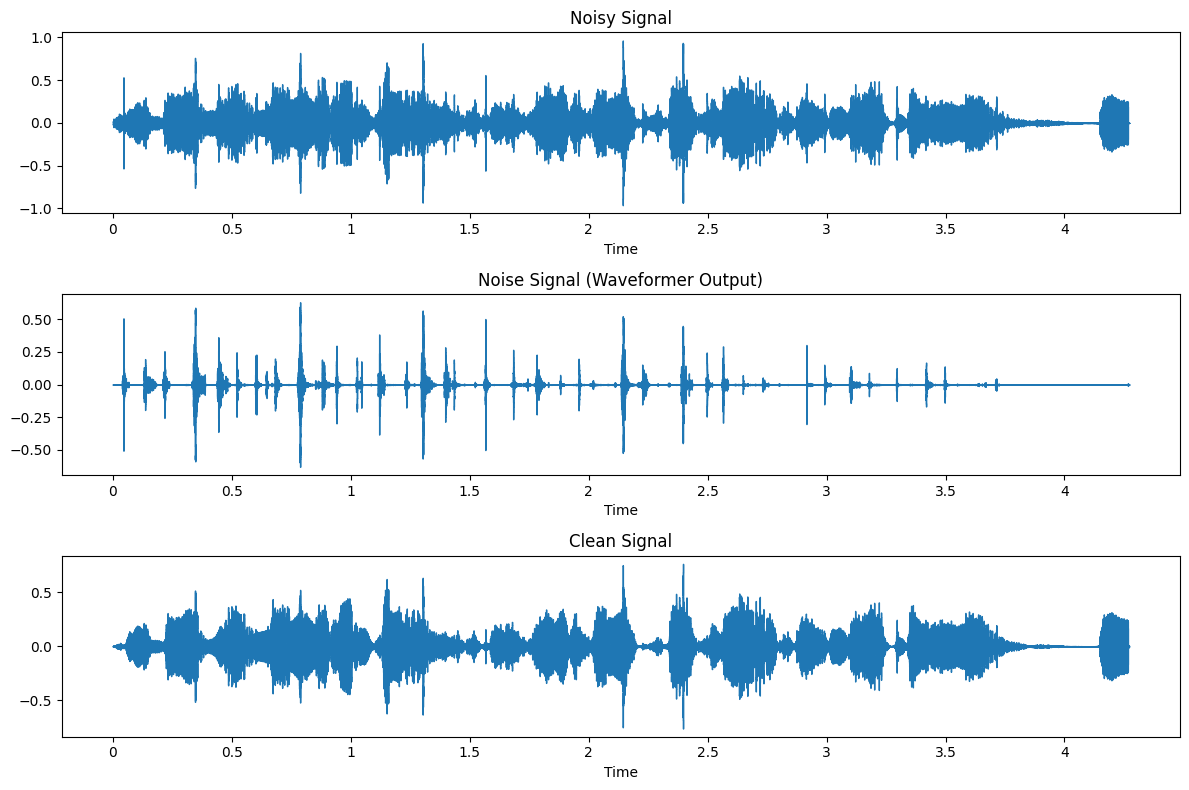

Enter the number of speakers in the audio (1-4): 2
Two speakers detected. Using Sepformer for 2 speakers.


hyperparams.yaml:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Resampling the audio from 44100 Hz to 8000 Hz
Separated Source 1: /content/output/source1hat.wav
Separated Source 2: /content/output/source2hat.wav


In [ ]:


import librosa
import numpy as np
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
import subprocess
import os
import soundfile as sf
import matplotlib.pyplot as plt
import torchaudio
from speechbrain.inference import SepformerSeparation as separator


# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)

# Load your trained model
model = load_model(model_path)

# Path to your sample audio file
sample_audio_file = '/content/Mixed_English_Typing.mp3'

# Extract features from the sample audio file
max_length = 700  # Adjust to match the model's expected input length
sample_features = extract_features(sample_audio_file, max_length=max_length)

# Reshape and preprocess the input for prediction
sample_features = sample_features[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Make predictions
predictions = model.predict(sample_features)

# Interpret predictions
predicted_label = np.argmax(predictions)
class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
predicted_class = class_labels[predicted_label]

print(f'The predicted class for the sample audio is: {predicted_class}')
print(f'Predicted probabilities: {predictions.squeeze()}')  # Optional: Print probabilities for each class

# Run Waveformer model with the predicted class as the target
# Clone the Waveformer repository and install dependencies if not already done
if not os.path.exists('Waveformer'):
    subprocess.run('git clone https://github.com/vb000/Waveformer', shell=True)
os.chdir('Waveformer')
subprocess.run('pip install -r requirements.txt', shell=True)
subprocess.run('pip install wget', shell=True)
subprocess.run('pip install speechbrain', shell=True)
subprocess.run('pip install torchmetrics', shell=True)

# Run the Waveformer model with the predicted class as the target
waveformer_input = f'python Waveformer.py "{sample_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
subprocess.run(waveformer_input, shell=True)

print(f'Waveformer model has processed the audio with target: {predicted_class}')

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    """Pad or trim the signal to the target length."""
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    # Pad or trim the noise signal to match the length of the noisy signal
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))

    # Calculate STFT of noisy and noise signals
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)

    # Compute the magnitude and phase
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)

    # Initialize the estimated magnitude of the clean signal
    magnitude_clean = magnitude_noisy.copy()

    # Initialize the noise estimate with the first few frames
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    # Perform spectral subtraction with smoothing
    for t in range(magnitude_noisy.shape[1]):
        # Update noise estimate using a smoothing factor
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]

        # Subtract noise estimate from the noisy signal magnitude
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    # Reconstruct the signal using the original phase
    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)

    return clean_signal

# Load the original noisy audio file
noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
# Load the noise output from the Waveformer model
noise_signal, _ = librosa.load('/content/output_audio.wav', sr=sr)

# Apply spectral subtraction
clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

# Save the clean audio
sf.write('/content/clean_signal.wav', clean_signal, sr)

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(noisy_signal, sr=sr)
plt.title('Noisy Signal')
plt.subplot(3, 1, 2)
librosa.display.waveshow(noise_signal, sr=sr)
plt.title('Noise Signal (Waveformer Output)')
plt.subplot(3, 1, 3)
librosa.display.waveshow(clean_signal, sr=sr)
plt.title('Clean Signal')
plt.tight_layout()
plt.show()

# Now take the output of the spectral subtraction as the input to the Sepformer below

!pip install speechbrain

def detect_speakers(path):
    # This function is a placeholder for actual speaker detection logic
    # Ideally, you would use a pre-trained model or other heuristic to detect the number of speakers
    # Here, we'll use a dummy implementation for illustration purposes
    # Return 1 for one speaker, 2 for two speakers, etc.
    return int(input("Enter the number of speakers in the audio (1-4): "))  # Dummy user input for demonstration

def clear_output_directory(output_dir):
    # Remove all files in the output directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

def separate_audio(path, num_speakers):
    # Define the output directory
    output_dir = "/content/output"
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Clear the output directory
    clear_output_directory(output_dir)

    if num_speakers == 1:
        print("Single speaker detected. Returning original audio.")
        return path  # Return the original path

    elif num_speakers == 2:
        print("Two speakers detected. Using Sepformer for 2 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav")]

    elif num_speakers == 3:
        print("Three speakers detected. Using Sepformer for 3 speakers.")
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav")]

    elif num_speakers == 4:
        print("Four speakers detected. Using Sepformer for 4 speakers.")
        subprocess.run('git clone https://github.com/hahmadraza/speechbrain_48k.git', shell=True)
        os.chdir('speechbrain_48k')
        subprocess.run('pip install -r requirements.txt', shell=True)
        subprocess.run('pip install --editable .', shell=True)
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix-48k/')
        est_sources = model.separate_file(path=path)
        torchaudio.save(os.path.join(output_dir, "source1hat.wav"), est_sources[:, :, 0].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source2hat.wav"), est_sources[:, :, 1].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source3hat.wav"), est_sources[:, :, 2].detach().cpu(), 8000)
        torchaudio.save(os.path.join(output_dir, "source4hat.wav"), est_sources[:, :, 3].detach().cpu(), 8000)
        return [os.path.join(output_dir, "source1hat.wav"), os.path.join(output_dir, "source2hat.wav"), os.path.join(output_dir, "source3hat.wav"), os.path.join(output_dir, "source4hat.wav")]

    else:
        print("Invalid number of speakers.")
        return None

clean_audio_file = '/content/clean_signal.wav'
num_speakers = detect_speakers(clean_audio_file)
separated_sources = separate_audio(clean_audio_file, num_speakers)

if separated_sources:
    if isinstance(separated_sources, list):
        for i, source_path in enumerate(separated_sources):
            print(f'Separated Source {i+1}: {source_path}')
    else:
        print(f'Single Source: {separated_sources}')


In [ ]:
pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.7

In [ ]:
import gradio as gr

# Define the function for processing audio
def process_audio(uploaded_file):
    # Save the uploaded file
    audio_path = "/content/Mixed_English_Typing.mp3"
    with open(audio_path, "wb") as f:
        f.write(uploaded_file.read())

    # Run your existing processing steps
    sample_audio_file = audio_path

    # Extract features and predict class
    sample_features = extract_features(sample_audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Run the Waveformer model
    waveformer_input = f'python Waveformer.py "{sample_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noisy and noise signals for spectral subtraction
    noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
    noise_signal, _ = librosa.load('/content/output_audio.wav', sr=sr)

    # Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Detect speakers
    num_speakers = detect_speakers(clean_audio_path)
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    # Return paths of the separated audio files
    return separated_sources if separated_sources else []

# Create Gradio interface
iface = gr.Interface(
    fn=process_audio,
    inputs=gr.inputs.Audio(source="upload", type="file", label="Upload Audio File"),
    outputs=gr.outputs.Audio(label="Separated Audio Files", type="list"),
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

# Launch the interface
iface.launch()


AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
import gradio as gr

# Define the function for processing audio
def process_audio(uploaded_file):
    # Save the uploaded file
    audio_path = "/content/uploaded_audio.wav"
    with open(audio_path, "wb") as f:
        f.write(uploaded_file.read())

    # Run your existing processing steps
    sample_audio_file = audio_path

    # Extract features and predict class
    sample_features = extract_features(sample_audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Run the Waveformer model
    waveformer_input = f'python Waveformer.py "{sample_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noisy and noise signals for spectral subtraction
    noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
    noise_signal, _ = librosa.load('/content/output_audio.wav', sr=sr)

    # Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Detect speakers
    num_speakers = detect_speakers(clean_audio_path)
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    # Return paths of the separated audio files
    return separated_sources if separated_sources else []

# Create Gradio interface
iface = gr.Interface(
    fn=process_audio,
    inputs=gr.Audio(source="upload", type="file", label="Upload Audio File"),
    outputs=gr.Audio(label="Separated Audio Files", type="list"),
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

# Launch the interface
iface.launch()


TypeError: Audio.__init__() got an unexpected keyword argument 'source'

In [ ]:
import gradio as gr

# Define the function for processing audio
def process_audio(uploaded_file):
    # Save the uploaded file
    audio_path = "/content/uploaded_audio.wav"
    with open(audio_path, "wb") as f:
        f.write(uploaded_file.read())

    # Run your existing processing steps
    sample_audio_file = audio_path

    # Extract features and predict class
    sample_features = extract_features(sample_audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Run the Waveformer model
    waveformer_input = f'python Waveformer.py "{sample_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noisy and noise signals for spectral subtraction
    noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
    noise_signal, _ = librosa.load('/content/output_audio.wav', sr=sr)

    # Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Detect speakers
    num_speakers = detect_speakers(clean_audio_path)
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    # Return paths of the separated audio files
    return separated_sources if separated_sources else []

# Create Gradio interface
iface = gr.Interface(
    fn=process_audio,
    inputs=gr.Audio(label="Upload Audio File"),
    outputs=gr.Audio(label="Separated Audio Files", type="list"),
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

# Launch the interface
iface.launch()


ValueError: Invalid value for parameter `type`: list. Please choose from one of: ['numpy', 'filepath']

In [ ]:
import gradio as gr

# Define the function for processing audio
def process_audio(uploaded_file):
    # Save the uploaded file
    audio_path = "/content/uploaded_audio.wav"
    with open(audio_path, "wb") as f:
        f.write(uploaded_file.read())

    # Run your existing processing steps
    sample_audio_file = audio_path

    # Extract features and predict class
    sample_features = extract_features(sample_audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Run the Waveformer model
    waveformer_input = f'python Waveformer.py "{sample_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noisy and noise signals for spectral subtraction
    noisy_signal, sr = librosa.load(sample_audio_file, sr=None)
    noise_signal, _ = librosa.load('/content/output_audio.wav', sr=sr)

    # Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Detect speakers
    num_speakers = detect_speakers(clean_audio_path)
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    # Return paths of the separated audio files
    return separated_sources if separated_sources else []

# Create Gradio interface
iface = gr.Interface(
    fn=process_audio,
    inputs=gr.Audio(label="Upload Audio File"),
    outputs=[gr.Audio(label=f"Separated Audio {i+1}", type="filepath") for i in range(4)],  # Adjust the number based on max speakers
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

# Launch the interface
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1bc2c722aa807d5582.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

def process_audio(audio_file, num_speakers):
    # Step 1: Save the uploaded audio file
    audio_path = audio_file.name  # Use .name to get the path
    with open(audio_path, "wb") as f:
        f.write(audio_file.read())

    # Step 2: Separate audio based on the number of speakers
    separated_sources = separate_audio(audio_path, num_speakers)

    if separated_sources:
        return separated_sources
    else:
        return "Error in separating audio."

iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(label="Upload Audio File"),
        gr.Slider(minimum=1, maximum=4, step=1, label="Number of Speakers", value=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath"),
    title="Audio Separation Tool",
    description="Upload an audio file and specify the number of speakers to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7eb5f886bb57fcb3b7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
import subprocess
import os
import soundfile as sf
import torchaudio
from speechbrain.inference import SepformerSeparation as separator

def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T

# Load your trained model
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)

    # Step 5: Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Step 6: Save clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 7: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    return separated_sources

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    return librosa.istft(clean_stft)

def pad_or_trim(signal, target_length):
    return signal[:target_length] if len(signal) > target_length else np.pad(signal, (0, target_length - len(signal)), 'constant')

def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)

    if num_speakers == 1:
        return [path]

    model = separator.from_hparams(source=f"speechbrain/sepformer-wsj0{num_speakers}mix", savedir='pretrained_models/sepformer')
    est_sources = model.separate_file(path=path)

    sources = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i + 1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        sources.append(source_path)

    return sources

# Gradio interface
import gradio as gr

iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(label="Upload Audio File"),
        gr.Slider(minimum=1, maximum=4, step=1, label="Number of Speakers", value=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath"),
    title="Audio Separation Tool",
    description="Upload an audio file and specify the number of speakers to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://21d339f95868e81c6e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(output_dir):
        os.unlink(os.path.join(output_dir, filename))  # Clear output directory

    if num_speakers == 1:
        return [path]  # Return the original path

    elif num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(2):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(3):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(4):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    else:
        raise ValueError("Invalid number of speakers.")

def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)

    # Step 5: Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Step 6: Save clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 7: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(source="upload", type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="list"),
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


TypeError: Audio.__init__() got an unexpected keyword argument 'source'

In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(output_dir):
        os.unlink(os.path.join(output_dir, filename))  # Clear output directory

    if num_speakers == 1:
        return [path]  # Return the original path

    elif num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(2):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(3):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(4):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    else:
        raise ValueError("Invalid number of speakers.")

def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)

    # Step 5: Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Step 6: Save clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 7: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="list"),
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


ValueError: Invalid value for parameter `type`: list. Please choose from one of: ['numpy', 'filepath']

In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(output_dir):
        os.unlink(os.path.join(output_dir, filename))  # Clear output directory

    if num_speakers == 1:
        return [path]  # Return the original path

    elif num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(2):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(3):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(4):
            source_path = os.path.join(output_dir, f"source{i+1}hat.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    else:
        raise ValueError("Invalid number of speakers.")

def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)

    # Step 5: Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Step 6: Save clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 7: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio File", type="filepath"),  # Use filepath for individual outputs
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7e88f5da29a602b99a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Define spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(output_dir):
        os.unlink(os.path.join(output_dir, filename))  # Clear output directory

    if num_speakers == 1:
        return [path]  # Return the original path

    elif num_speakers in [2, 3, 4]:
        model = separator.from_hparams(source=f"speechbrain/sepformer-wsj0{num_speakers}mix", savedir='pretrained_models/')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(num_speakers):
            source_path = os.path.join(output_dir, f"source{i+1}.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    else:
        raise ValueError("Invalid number of speakers.")

def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)

    # Step 5: Apply spectral subtraction
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Step 6: Save clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 7: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)

    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath"),  # Changed to handle single file
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d4c72becabd23b529d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)

    if num_speakers == 1:
        return [path]  # Return the original path

    elif num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(num_speakers):
            source_path = os.path.join(output_dir, f"source{i+1}.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(num_speakers):
            source_path = os.path.join(output_dir, f"source{i+1}.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')
        est_sources = model.separate_file(path=path)
        source_paths = []
        for i in range(num_speakers):
            source_path = os.path.join(output_dir, f"source{i+1}.wav")
            torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
            source_paths.append(source_path)
        return source_paths

    else:
        raise ValueError("Invalid number of speakers.")

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 5: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath"),  # Outputs file paths
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1e222bc608a0ccb11f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)

    if num_speakers == 1:
        return [path]  # Return the original path

    model = None
    if num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 5: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources  # Return file paths for Gradio

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath", multiple=True),  # Multiple file paths
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


TypeError: Audio.__init__() got an unexpected keyword argument 'multiple'

In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)

    if num_speakers == 1:
        return [path]  # Return the original path

    model = None
    if num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 5: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources  # Return file paths for Gradio

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Audio(label="Separated Audio Files", type="filepath"),  # Single output for the list of separated files
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://fcfc092bbf8deafb51.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import librosa
import numpy as np
import soundfile as sf
import subprocess
import os
import torchaudio
import gradio as gr
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as separator

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)

    if num_speakers == 1:
        return [path]  # Return the original path

    model = None
    if num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix/')

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Function for spectral subtraction (Assuming this function exists)
def spectral_subtraction(noisy_signal, noise_signal, sr):
    # Spectral subtraction implementation here
    noise_stft = librosa.stft(noise_signal)
    noisy_stft = librosa.stft(noisy_signal)
    magnitude_noise = np.abs(noise_stft)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_clean = np.maximum(magnitude_noisy - magnitude_noise, 0)
    clean_stft = magnitude_clean * np.exp(1.j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Step 1: Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Step 2: Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Step 3: Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Step 4: Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Step 5: Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources  # Return file paths for Gradio

# Gradio Interface
def gradio_process(audio_file, num_speakers):
    separated_sources = process_audio(audio_file, num_speakers)
    return tuple(separated_sources)

iface = gr.Interface(
    fn=gradio_process,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=[gr.Audio(type="filepath", label=f"Speaker {i+1} Audio") for i in range(4)],  # Outputs for up to 4 speakers
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e543fc1e03d0f5fc18.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import os
import torch
import torchaudio
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from speechbrain.inference import SepformerSeparation as Separator

# Load the trained CNN model
cnn_model = load_model('speaker_recognition_cnn.h5')

# Load Sepformer model
sepformer_model = Separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')

# Function to extract features (MFCCs) with fixed length
def extract_features(audio, sr=16000, n_mfcc=13, max_length=None):
    if isinstance(audio, str):
        y, sr = librosa.load(audio, sr=sr)
    else:
        y = audio

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = librosa.util.normalize(mfccs)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T

# Function to classify speaker
def classify_speaker(mfcc_feature, cnn_model):
    mfcc_feature = np.expand_dims(mfcc_feature, axis=(0, -1))  # Add batch and channel dimensions
    prediction = cnn_model.predict(mfcc_feature)
    print("Prediction: ", prediction)  # Log prediction
    predicted_label = np.argmax(prediction)
    return 'hemachandra' if predicted_label == 0 else 'vidhathri'

# Function to separate and classify speakers from the mixed audio file
def separate_and_classify(mixed_audio_file):
    est_sources = sepformer_model.separate_file(path=mixed_audio_file)

    output_files = []
    os.makedirs("separated_audio", exist_ok=True)
    for i in range(est_sources.shape[2]):
        source = est_sources[:, :, i].detach().cpu().numpy().squeeze()
        # Resample to 8000 Hz if needed
        source = librosa.resample(source, orig_sr=44100, target_sr=8000) if est_sources.shape[1] == 44100 else source
        # Extract features
        mfcc_feature = extract_features(source, sr=8000, max_length=500)
        # Log extracted features
        print("MFCC Feature Shape: ", mfcc_feature.shape)
        # Classify speaker
        speaker_name = classify_speaker(mfcc_feature, cnn_model)
        # Save the separated audio
        output_file = f'separated_audio/{speaker_name}separated{i+1}.wav'
        torchaudio.save(output_file, torch.tensor(source).unsqueeze(0), 8000)
        print(f'Saved separated audio to {output_file}')
        output_files.append(output_file)

    return output_files

# Define the Gradio interface
def recognize_and_save_speakers(audio_file):
    output_files = separate_and_classify(audio_file)
    return output_files

iface = gr.Interface(
    fn=recognize_and_save_speakers,
    inputs=gr.Audio(type="filepath"),
    outputs=gr.Files(),  # Use gr.Files() to handle multiple output files
    title="Speaker Recognition and Separation",
    description="Upload a mixed audio file to separate and classify the speakers. The separated audio files will be saved and displayed below."
)

# Launch the interface
iface.launch()

OSError: No file or directory found at speaker_recognition_cnn.h5

In [ ]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
import gradio as gr
import os
import torch
import torchaudio
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as Separator
import subprocess
import soundfile as sf
import matplotlib.pyplot as plt

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def clear_output_directory(output_dir):
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    clear_output_directory(output_dir)

    if num_speakers == 1:
        return [path]

    elif num_speakers == 2:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        subprocess.run('git clone https://github.com/hahmadraza/speechbrain_48k.git', shell=True)
        os.chdir('speechbrain_48k')
        subprocess.run('pip install -r requirements.txt', shell=True)
        subprocess.run('pip install --editable .', shell=True)
        model = separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix-48k/')
    else:
        return None

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Files(),  # Use gr.Files() to handle multiple output files
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://698959f4b5067138a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 152ms/step
Resampling the audio from 44100 Hz to 8000 Hz
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://698959f4b5067138a8.gradio.live


In [ ]:
!pip install speechbrain gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 M

In [ ]:
import gradio as gr
import os
import torch
import torchaudio
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as Separator
import subprocess
import soundfile as sf
import matplotlib.pyplot as plt

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def clear_output_directory(output_dir):
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    clear_output_directory(output_dir)

    if num_speakers == 1:
        return [path]

    elif num_speakers == 2:
        model = Separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = Separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        subprocess.run('git clone https://github.com/hahmadraza/speechbrain_48k.git', shell=True)
        os.chdir('speechbrain_48k')
        subprocess.run('pip install -r requirements.txt', shell=True)
        subprocess.run('pip install --editable .', shell=True)
        model = Separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix-48k/')
    else:
        return None

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Clone and set up Waveformer if not already done
    if not os.path.exists('Waveformer'):
        subprocess.run('git clone https://github.com/vb000/Waveformer', shell=True)
    os.chdir('Waveformer')
    subprocess.run('pip install -r requirements.txt', shell=True)
    subprocess.run('pip install wget', shell=True)
    subprocess.run('pip install speechbrain', shell=True)
    subprocess.run('pip install torchmetrics', shell=True)

    # Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Files(),  # Use gr.Files() to handle multiple output files
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b15153fc8242469f21.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 118ms/step


hyperparams.yaml:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 38ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 46ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 40ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 38ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 37ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 38ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 99ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 38ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 41ms/step
Resampling the audio from 44100 Hz to 8000 Hz
1/1 [==============================] - 0s 37ms/step
Resampling the audio

In [3]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.5

In [1]:
import gradio as gr
import os
import torch
import torchaudio
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from huggingface_hub import hf_hub_download
from speechbrain.inference import SepformerSeparation as Separator
import subprocess
import soundfile as sf
import matplotlib.pyplot as plt

# Function to extract features (MFCCs) with fixed length
def extract_features(audio_file, sr=16000, n_mfcc=13, max_length=None):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if max_length:
        mfccs = librosa.util.fix_length(mfccs, size=max_length)
    return mfccs.T  # Transpose to match model's input shape

# Download and load your trained model from Hugging Face
model_repo_id = 'maithal/classifier'
model_filename = 'trained_model_multi.h5'
model_path = hf_hub_download(repo_id=model_repo_id, filename=model_filename)
model = load_model(model_path)

# Spectral subtraction functions
def pad_or_trim(signal, target_length):
    if len(signal) > target_length:
        return signal[:target_length]
    else:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')

def spectral_subtraction(noisy_signal, noise_signal, sr, alpha=4.0, beta=0.002, smoothing_factor=0.98):
    noise_signal = pad_or_trim(noise_signal, len(noisy_signal))
    noisy_stft = librosa.stft(noisy_signal)
    noise_stft = librosa.stft(noise_signal)
    magnitude_noisy = np.abs(noisy_stft)
    phase_noisy = np.angle(noisy_stft)
    magnitude_noise = np.abs(noise_stft)
    magnitude_clean = magnitude_noisy.copy()
    noise_estimate = np.mean(magnitude_noise[:, :5], axis=1, keepdims=True)

    for t in range(magnitude_noisy.shape[1]):
        noise_estimate = smoothing_factor * noise_estimate + (1 - smoothing_factor) * magnitude_noise[:, t:t+1]
        magnitude_clean[:, t] = np.maximum(magnitude_noisy[:, t] - alpha * noise_estimate[:, 0], beta * noise_estimate[:, 0])

    clean_stft = magnitude_clean * np.exp(1j * phase_noisy)
    clean_signal = librosa.istft(clean_stft)
    return clean_signal

def clear_output_directory(output_dir):
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)

# Function to separate audio using Sepformer
def separate_audio(path, num_speakers):
    output_dir = "/content/output"
    os.makedirs(output_dir, exist_ok=True)
    clear_output_directory(output_dir)

    if num_speakers == 1:
        return [path]

    elif num_speakers == 2:
        model = Separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
    elif num_speakers == 3:
        model = Separator.from_hparams(source="speechbrain/sepformer-wsj03mix", savedir='pretrained_models/sepformer-wsj03mix')
    elif num_speakers == 4:
        subprocess.run('git clone https://github.com/hahmadraza/speechbrain_48k.git', shell=True)
        os.chdir('speechbrain_48k')
        subprocess.run('pip install -r requirements.txt', shell=True)
        subprocess.run('pip install --editable .', shell=True)
        model = Separator.from_hparams(source="hahmadraz/sepformer-libri4mix", savedir='pretrained_models/sepformer-libri4mix-48k/')
    else:
        return None

    est_sources = model.separate_file(path=path)
    source_paths = []
    for i in range(num_speakers):
        source_path = os.path.join(output_dir, f"source{i+1}.wav")
        torchaudio.save(source_path, est_sources[:, :, i].detach().cpu(), 8000)
        source_paths.append(source_path)
    return source_paths

# Main audio processing function
def process_audio(audio_file, num_speakers):
    # Extract features
    max_length = 700
    sample_features = extract_features(audio_file, max_length=max_length)
    sample_features = sample_features[np.newaxis, ..., np.newaxis]

    # Make predictions
    predictions = model.predict(sample_features)
    predicted_label = np.argmax(predictions)
    class_labels = ['Meow', 'Bark', 'Cough', 'Computer_keyboard']
    predicted_class = class_labels[predicted_label]

    # Clone and set up Waveformer if not already done
    if not os.path.exists('Waveformer'):
        subprocess.run('git clone https://github.com/vb000/Waveformer', shell=True)
    os.chdir('Waveformer')
    subprocess.run('pip install -r requirements.txt', shell=True)
    subprocess.run('pip install wget', shell=True)
    subprocess.run('pip install speechbrain', shell=True)
    subprocess.run('pip install torchmetrics', shell=True)

    # Convert the input audio to mono
    y, sr = librosa.load(audio_file, sr=None, mono=True)
    mono_audio_file = '/content/mono_audio.wav'
    sf.write(mono_audio_file, y, sr)

    # Run Waveformer model with the predicted class
    waveformer_input = f'python Waveformer.py "{mono_audio_file}" /content/output_audio.wav --targets "{predicted_class}"'
    subprocess.run(waveformer_input, shell=True)

    # Load the noise output and apply spectral subtraction
    noise_signal, sr = librosa.load('/content/output_audio.wav', sr=None)
    noisy_signal, _ = librosa.load(audio_file, sr=None)
    clean_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

    # Save the clean audio
    clean_audio_path = '/content/clean_signal.wav'
    sf.write(clean_audio_path, clean_signal, sr)

    # Separate audio sources
    separated_sources = separate_audio(clean_audio_path, num_speakers)
    return separated_sources

# Gradio Interface
iface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(type="filepath", label="Upload Audio File"),
        gr.Number(value=1, label="Number of Speakers (1-4)", precision=0, step=1)
    ],
    outputs=gr.Files(),  # Use gr.Files() to handle multiple output files
    title="Audio Separation Tool",
    description="Upload an audio file to separate different sound sources."
)

iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b9c18ed2fd0a90aebf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 154ms/step


hyperparams.yaml:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Resampling the audio from 48000 Hz to 8000 Hz
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b9c18ed2fd0a90aebf.gradio.live
